# 45th solution for Intel & MobileODT Cervical Cancer Screening challenge
### Which cancer treatment will be most effective?

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.cluster import KMeans

from data_preprocessing import preprocess_one_image
# from kmeans_validation import compute_histograms
# Disable DeprecationWarnings which may be irritating.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
def compute_histogram(img, hist_size=100):
    hist = cv2.calcHist([img], [0], mask=None, histSize=[hist_size], ranges=(0, 255))
    hist = cv2.normalize(hist, dst=hist)
    return hist

## Data preprocessing
We used approach from https://www.kaggle.com/chattob/cervix-segmentation-gmm

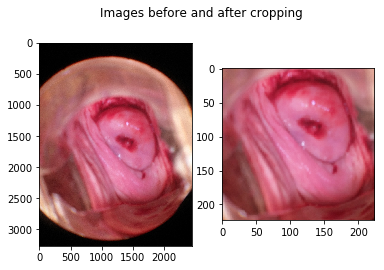

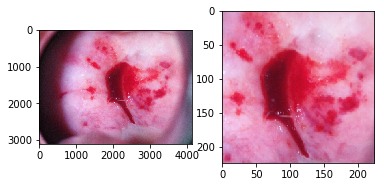

In [3]:
# This part is quite expensive. It can take a few minutes to compute it. To preprocess
# all images from training and test sets it is convenient to use preprocess_all_data.py script.
DATA_PATH = '/home/maciej/intel/data/'

img = plt.imread(DATA_PATH + 'raw_data/train/Type_1/0.jpg')
# tile_size make the computation faster, smaller - faster and worser (quality)
img_preprocessed = preprocess_one_image(DATA_PATH + 'raw_data/train/Type_1/0.jpg', 
                                        tile_size=(1024, 1024)) 
img1 = plt.imread(DATA_PATH + 'raw_data/train/Type_2/1006.jpg')
img1_preprocessed = preprocess_one_image(DATA_PATH + 'raw_data/train/Type_2/1006.jpg',
                                        tile_size=(1024, 1024))
plt.figure()
plt.suptitle('Images before and after cropping')
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_preprocessed)
plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img1_preprocessed)
plt.show()

## Validation - the most important task in this challenge.

In [4]:
X_train = pd.read_pickle(DATA_PATH + 'pikle/X_train')
X_additional = np.load(DATA_PATH + 'pikle/X_additional.npy')
X_all = np.concatenate([X_train, X_additional])

y_train = pd.read_pickle(DATA_PATH + 'pikle/y_train')
y_additional = np.load(DATA_PATH + 'pikle/y_additional.npy')
y_all = np.concatenate([y_train, y_additional])

hist_size = 100
X = np.zeros((X_all.shape[0], 3*hist_size), dtype=np.float32)

print "Computing histograms..."
for i in range(X_all.shape[0]):

    img = X_all[i,:,:,:]


    proc = cv2.GaussianBlur(img.copy(), (7, 7), 0)
    hsv = cv2.cvtColor(proc, cv2.COLOR_RGB2HSV)
    hue = hsv[:,:,0]
    sat = hsv[:,:,1]
    val = hsv[:,:,2]

    hist_hue = compute_histogram(hue, hist_size)
    hist_sat = compute_histogram(sat, hist_size)    
    hist_val = compute_histogram(val, hist_size)
    X[i, 0:hist_size] = hist_hue[:,0]
    X[i, hist_size:2*hist_size] = hist_sat[:,0]
    X[i, 2*hist_size:] = hist_val[:,0] 
print "Done"

Computing histograms...
Done


In [5]:
kmeans = KMeans(n_clusters=100)
labels = kmeans.fit_predict(X)

In [6]:
image_size = (256, 256)

In [7]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image/255.)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Plotting some example clusters from KMeans (K=100)
This method of validation was used by winners of the competition.

You can see tha similar images are grouped together, so histograms are quite good transformation of the images before fitting KMeans.

To validation set we should select about 10-15 groups. We are trying to separate both groups to have as much different images as it is possible. We want to have true, stable results and avoid overfitting to images from train set during training using early stopping.  

In [8]:
show_images(X_all[labels == 88][:12], cols=4)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


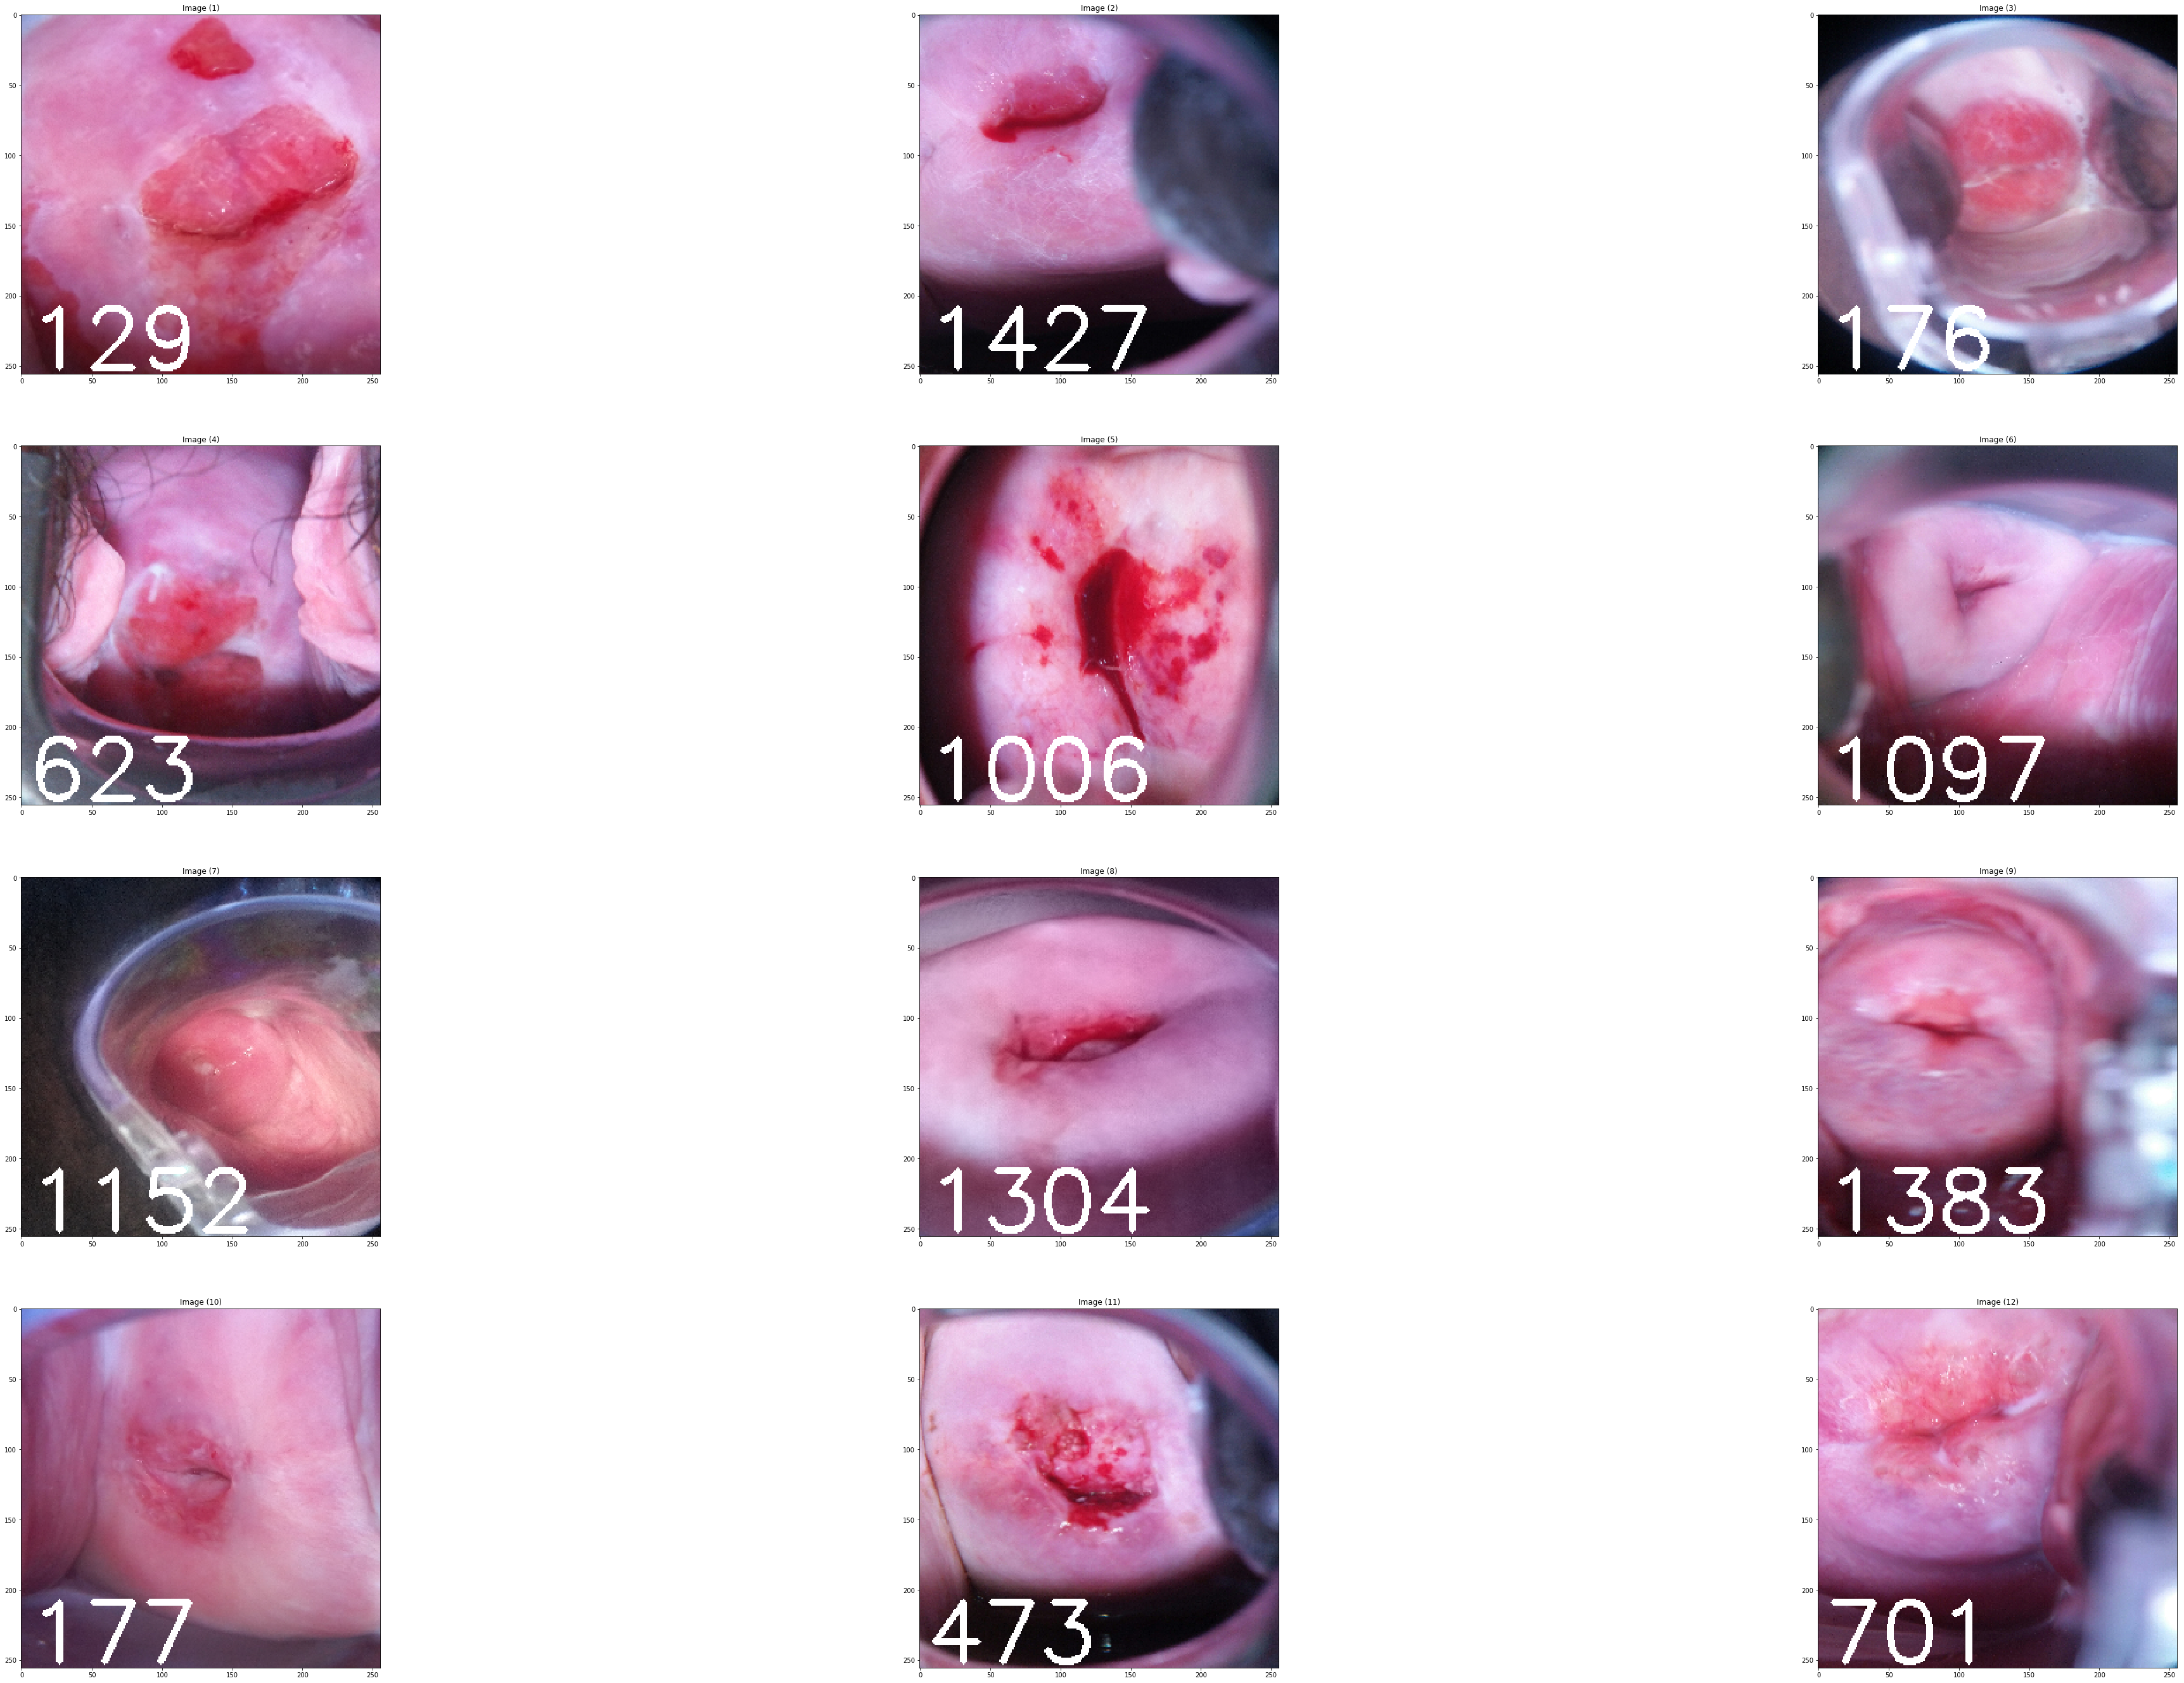

In [9]:
show_images(X_all[labels == 71][:12], cols=4)

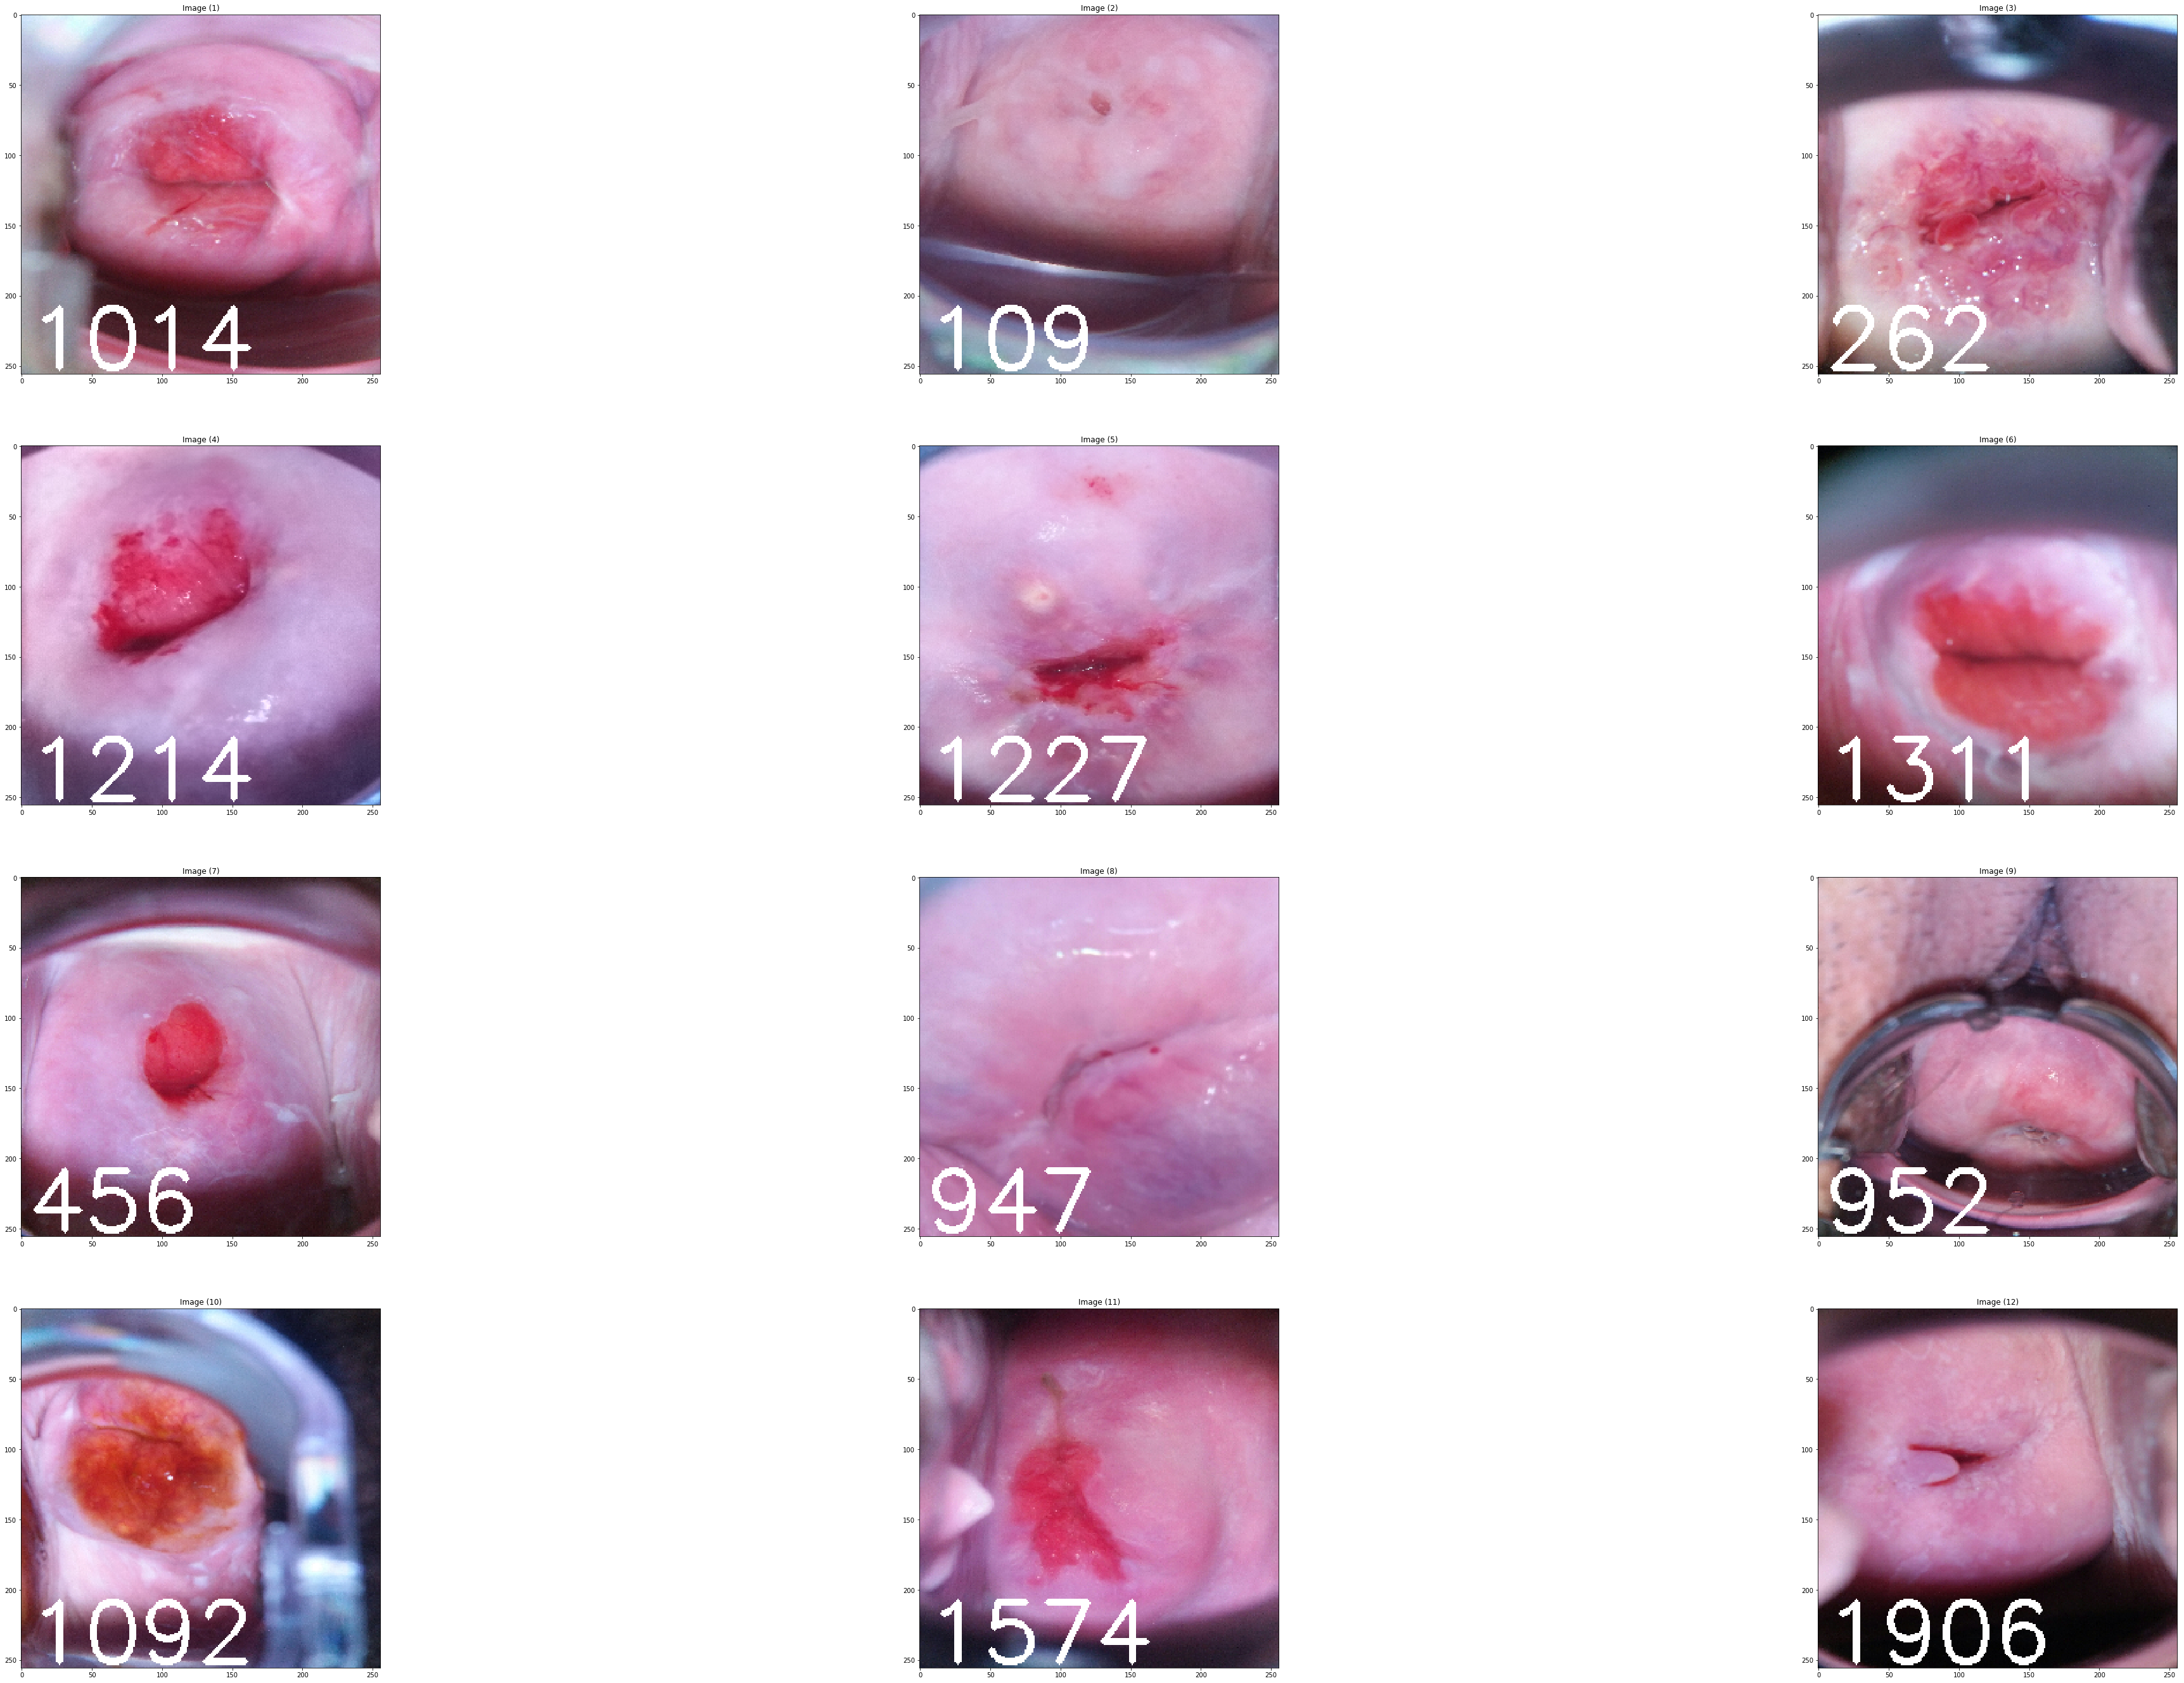

In [10]:
show_images(X_all[labels == 34][:12], cols=4)

In [11]:
show_images(X_all[labels == 27][:12], cols=4)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


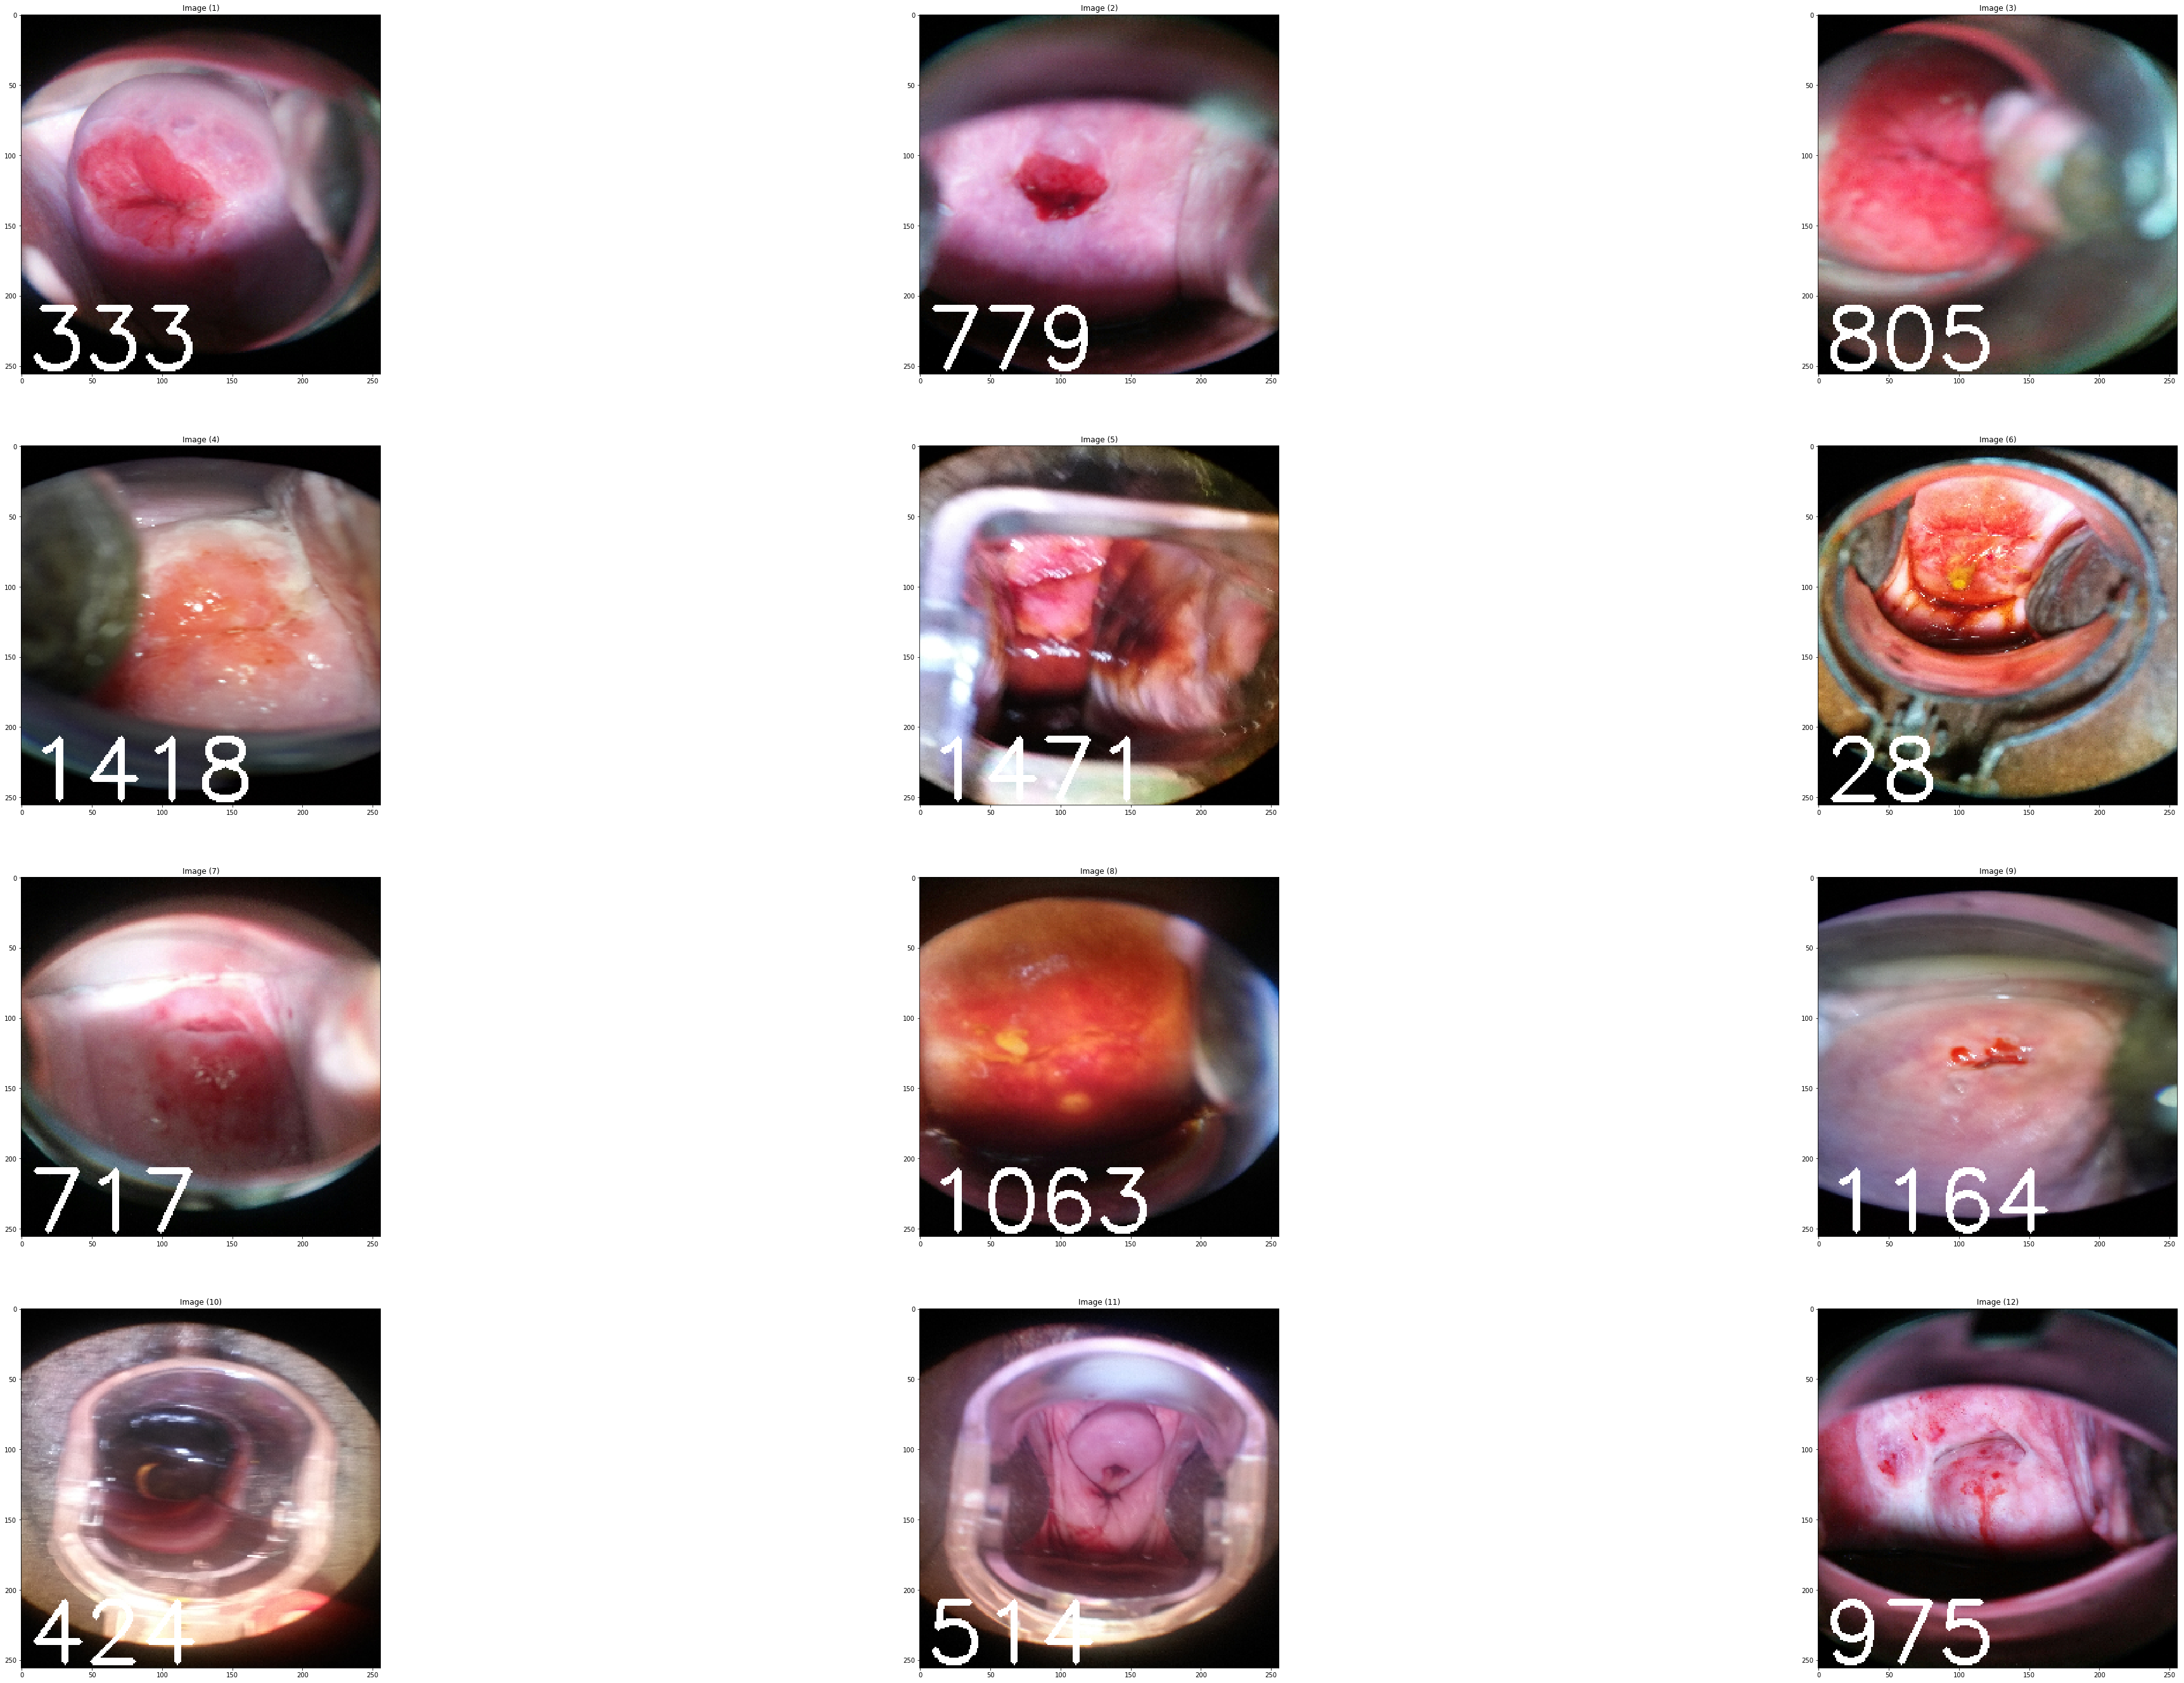

In [12]:
show_images(X_all[labels == 13][:12], cols=4)

In [13]:
X_val = X_all[labels < 15]
y_val = y_all[labels < 15]
X_train = X_all[labels >= 15]
y_train = y_all[labels >= 15]

In [19]:
from train_net import train_model,test_augmentation
from keras.applications import InceptionV3
from keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model

In [18]:
# Definition of model we will train
base_model = InceptionV3(include_top=False, weights='imagenet',
                         input_tensor=None,
                         input_shape=(224, 224, 3), classes=3)
x = base_model.output
x = Conv2D(512, (3, 3))(x)
x = GlobalMaxPooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers[:-5]:
    layer.trainable = False
    
model.compile(
        optimizer=keras.optimizers.sgd(lr=0.001, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy')
# First training with only 5 layers trainable
model, datagen = train_model(model=model, batch_size=32, num_classes=3, epochs=40, data_augmentation=True,
                             model_name='example.hdf5', 
                             X_train_train=X_train[:, 16:240, 16:240, :], 
                             y_train_train=y_train,
                             X_test_train=X_val[:, 16:240, 16:240, :], 
                             y_test_train=y_val)

for layer in model.layers[:-5]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.adam(lr=0.0001),
              loss='categorical_crossentropy')
# Second training with all layers trainable
model, datagen = train_model(model, 32, 3, 40, True, 'example.hdf5',
                             X_train_train=X_train[:, 16:240, 16:240, :], 
                             y_train_train=y_train,
                             X_test_train=X_val[:, 16:240, 16:240, :], 
                             y_test_train=y_val)

('x_train shape:', (6581, 224, 224, 3))
(6581, 'train samples')
(1566, 'test samples')
Using real-time data augmentation.
Epoch 1/40
205/205 [==============================] - 99s - loss: 1.0631 - val_loss: 1.0058
Epoch 2/40
205/205 [==============================] - 66s - loss: 0.9739 - val_loss: 0.9644
Epoch 3/40
205/205 [==============================] - 65s - loss: 0.9652 - val_loss: 0.9875
Epoch 4/40
205/205 [==============================] - 65s - loss: 0.9512 - val_loss: 0.9646
Epoch 5/40
205/205 [==============================] - 66s - loss: 0.9458 - val_loss: 0.9470
Epoch 6/40
205/205 [==============================] - 65s - loss: 0.9369 - val_loss: 0.9569
Epoch 7/40
205/205 [==============================] - 65s - loss: 0.9382 - val_loss: 0.9549
Epoch 8/40
205/205 [==============================] - 65s - loss: 0.9320 - val_loss: 0.9511
Epoch 9/40
205/205 [==============================] - 65s - loss: 0.9278 - val_loss: 0.9572
Epoch 10/40
205/205 [=============================

In [27]:
X_test_1st_stage = pd.read_pickle(DATA_PATH + 'wyciete_z_wiekszych_ostateczne/X_test_cut')
X_test_1st_stage_file_names = pd.read_pickle(DATA_PATH + 'wyciete_z_wiekszych_ostateczne/X_test_file_name')
y_test_true_labels_1st_stage = pd.read_csv(DATA_PATH + 'solution_stg1_release.csv')

In [28]:
X_test_sorted = []
for i in y_test_true_labels_1st_stage['image_name']:
    X_test_sorted.append(X_test_1st_stage[np.where(X_test_1st_stage_file_names == i[:-4])])
X_test_sorted = np.squeeze(np.array(X_test_sorted))

In [31]:
y_test_sorted = np.argmax(y_test_true_labels_1st_stage.iloc[:, 1:].values, 1)

In [33]:
preds = test_augmentation(model, datagen, X_test_sorted, n_iter=2)

Predictions are being computed...


train_net.py:68: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<keras.pre..., 16, use_multiprocessing=True)`
  X.shape[0] / 32, pickle_safe=True))


In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [59]:
print "Accuracy: {}".format(accuracy_score(y_test_sorted, np.argmax(preds, axis=1)))
print "Percentage of labels: ", np.unique(y_test_sorted, return_counts=True)[1]/512.
print "Percentage of preds: ", np.unique(np.argmax(preds, axis=1), return_counts=True)[1]/512.
print "Log loss: {}".format(log_loss(y_test_sorted, preds))
print "Confusion matrix: "
pd.DataFrame(confusion_matrix(y_test_sorted, np.argmax(preds, axis=1)), columns=['0', '1', '2'], index=[0, 1, 2])

Accuracy: 0.623046875
Percentage of labels:  [ 0.16992188  0.51757812  0.3125    ]
Percentage of preds:  [ 0.03125   0.546875  0.421875]
Log loss: 0.87725993385
Confusion matrix: 


0    1    2
0  13   55   19
1   2  186   77
2   1   39  120

# Checking which parts of images are the most important

In [67]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

[[ 0.28574204  0.48277947  0.23147854]] True label:  2


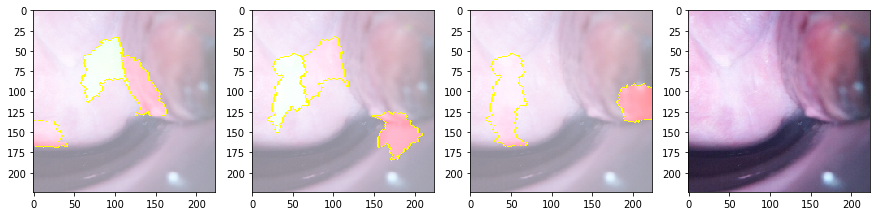

In [76]:
ex = 15
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test_sorted[ex]/255., classifier_fn=model.predict,
                                        top_labels=3, hide_color=0)

plt.figure(figsize=(15,12))
plt.subplot(141)
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(142)
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.00000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(143)
temp, mask = explanation.get_image_and_mask(2, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.0000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

plt.subplot(144)
plt.imshow(X_test_sorted[ex]/255.)

print model.predict(X_test_sorted[ex:ex+1]/255.), "True label: ", y_test_sorted[ex]

(array([[ 0.28351566,  0.48704302,  0.22944134]], dtype=float32), 1)

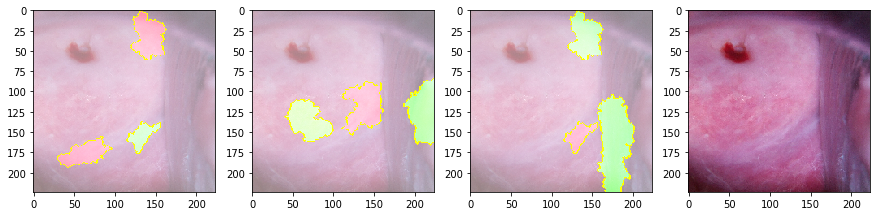

In [77]:
ex = 8
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(X_test_sorted[ex]/255., classifier_fn=model.predict,
                                        top_labels=3, hide_color=0)

plt.figure(figsize=(15,12))
plt.subplot(141)
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(142)
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.00000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.subplot(143)
temp, mask = explanation.get_image_and_mask(2, positive_only=False, num_features=3, hide_rest=False,
                                           min_weight=0.0000005)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

plt.subplot(144)
plt.imshow(X_test_sorted[ex]/255.)

model.predict(X_test_sorted[ex:ex+1]/255.), y_test_sorted[ex]